In [1]:
# ============================================================================
# 셀 1: 라이브러리 임포트
# ============================================================================
import os
import glob
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


In [2]:
# ============================================================================
# 셀 2: 데이터 로딩
# ============================================================================

# curated 폴더의 모든 CSV 파일 로드
csv_files = glob.glob("../data/curated/*.csv")
print(f"🕵🏻 발견된 csv 파일 : {len(csv_files)}개")
print("=" * 60) # 구분선

# 파일별로 개별 로드 및 정보 출력
df_list = []
for i, file in enumerate(csv_files, 1):
    temp_df = pd.read_csv(file)
    temp_df['source_file'] = file.split('/')[-1]  # 파일명 추가
    df_list.append(temp_df)
    
    # 파일별 상세 정보 출력
    print(f"{i}. 파일명 {file.split('/')[-1]}") #
    print(f"   데이터정보: {temp_df.shape[0]:,}행 × {temp_df.shape[1]}열") 
    print(f"   💾 메모리: {temp_df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
    print(f"   ❌ 결측값: {temp_df.isnull().sum().sum():,}개")
    print("-" * 40)

# 모든 CSV 파일을 하나의 DataFrame으로 합치기
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
print(f"✅ 전체 데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열")

# 데이터 복사본 생성
df_analysis = df.copy()

🕵🏻 발견된 csv 파일 : 3개
1. 파일명 curated\player_final.csv
   데이터정보: 6,910행 × 25열
   💾 메모리: 5.9MB
   ❌ 결측값: 2,411개
----------------------------------------
2. 파일명 curated\test_df.csv
   데이터정보: 1,442행 × 28열
   💾 메모리: 1.3MB
   ❌ 결측값: 370개
----------------------------------------
3. 파일명 curated\train_df.csv
   데이터정보: 14,873행 × 28열
   💾 메모리: 13.1MB
   ❌ 결측값: 5,101개
----------------------------------------
✅ 전체 데이터 로드 완료: 23,225행 × 28열


In [3]:
# ============================================================================
# 셀 3: 데이터 기본 정보 확인 (파일별)
# ============================================================================

print("📊 curated 폴더 데이터 기본 정보 (파일별):")
print("=" * 60)

# curated 폴더의 모든 CSV 파일 로드
csv_files = glob.glob("../data/curated/*.csv")
print(f"🕵🏻 발견된 CSV 파일: {len(csv_files)}개")

if not csv_files:
    print("❌ curated 폴더에 CSV 파일이 없습니다.")
else:
    # 파일별로 개별 로드 및 정보 출력
    df_list = []
    for i, file in enumerate(csv_files, 1):
        # temp_df로 각 파일 로드
        temp_df = pd.read_csv(file)
        temp_df['source_file'] = file.split('/')[-1]  # 파일명 추가
        df_list.append(temp_df)
        
        print(f"\n📁 {i}. {file.split('/')[-1]}:")
        print(f"   📊 데이터 크기: {temp_df.shape[0]:,}행 × {temp_df.shape[1]}열")
        print(f"   💾 메모리: {temp_df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
        print(f"   ❌ 결측값: {temp_df.isnull().sum().sum():,}개")
        
        # 이적률 확인 (transfer 컬럼이 있는 경우)
        if 'transfer' in temp_df.columns:
            print(f"   🔄 이적률: {temp_df['transfer'].mean()*100:.1f}%")
        else:
            print(f"   ⚠️ transfer 컬럼 없음")
        
        # 컬럼 타입 분류
        numeric_cols = temp_df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = temp_df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"   📋 수치형: {len(numeric_cols)}개, 범주형: {len(categorical_cols)}개")
        print("-" * 50)
    
    # 모든 파일을 하나의 DataFrame으로 합치기
    df = pd.concat(df_list, ignore_index=True)
    df_analysis = df.copy()
    
    print(f"\n✅ 전체 데이터 로드 완료:")
    print(f"   📊 총 크기: {df.shape[0]:,}행 × {df.shape[1]}열")
    print(f"   �� 총 메모리: {df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
    print(f"   ❌ 총 결측값: {df.isnull().sum().sum():,}개")
    
    if 'transfer' in df.columns:
        print(f"   🔄 전체 이적률: {df['transfer'].mean()*100:.1f}%")
    
    # 전체 컬럼 타입 분류
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"   📋 전체 수치형: {len(numeric_cols)}개, 범주형: {len(categorical_cols)}개")
    
    # 파일별 상세 분석
    print(f"\n📊 파일별 상세 분석:")
    print("=" * 60)
    
    for source_file in df_analysis['source_file'].unique():
        # temp_df로 각 파일의 데이터 추출
        temp_df = df_analysis[df_analysis['source_file'] == source_file]
        
        print(f"\n📁 {source_file}:")
        print(f"   📊 레코드 수: {len(temp_df):,}개")
        print(f"   🔄 이적률: {temp_df['transfer'].mean()*100:.1f}%")
        print(f"   ❌ 결측값 비율: {(temp_df.isnull().sum().sum()/len(temp_df)/len(temp_df.columns)*100):.1f}%")
        
        # 컬럼 타입 분류
        numeric_cols = temp_df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = temp_df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"   📋 수치형: {len(numeric_cols)}개, 범주형: {len(categorical_cols)}개")
        print("-" * 40)

📊 curated 폴더 데이터 기본 정보 (파일별):
🕵🏻 발견된 CSV 파일: 3개

📁 1. curated\player_final.csv:
   📊 데이터 크기: 6,910행 × 25열
   💾 메모리: 5.9MB
   ❌ 결측값: 2,411개
   🔄 이적률: 14.6%
   📋 수치형: 14개, 범주형: 11개
--------------------------------------------------

📁 2. curated\test_df.csv:
   📊 데이터 크기: 1,442행 × 28열
   💾 메모리: 1.3MB
   ❌ 결측값: 370개
   🔄 이적률: 30.3%
   📋 수치형: 17개, 범주형: 11개
--------------------------------------------------

📁 3. curated\train_df.csv:
   📊 데이터 크기: 14,873행 × 28열
   💾 메모리: 13.1MB
   ❌ 결측값: 5,101개
   🔄 이적률: 16.9%
   📋 수치형: 17개, 범주형: 11개
--------------------------------------------------

✅ 전체 데이터 로드 완료:
   📊 총 크기: 23,225행 × 29열
   �� 총 메모리: 20.6MB
   ❌ 총 결측값: 51,837개
   🔄 전체 이적률: 17.0%
   📋 전체 수치형: 18개, 범주형: 11개

📊 파일별 상세 분석:

📁 curated\player_final.csv:
   📊 레코드 수: 6,910개
   🔄 이적률: 14.6%
   ❌ 결측값 비율: 15.0%
   📋 수치형: 18개, 범주형: 11개
----------------------------------------

📁 curated\test_df.csv:
   📊 레코드 수: 1,442개
   🔄 이적률: 30.3%
   ❌ 결측값 비율: 4.3%
   📋 수치형: 18개, 범주형: 11개
------------------------

# New Features

## 칼럼 drop
## - 범주형에서만 뺄거임(수치형 남김)
### (player_name, date_of_birth, agent_name, net_transfer_record )

In [4]:
print(df.columns.tolist())

len(df.columns)

['season', 'player_name', 'goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'club_name', 'country_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'agent_name', 'net_transfer_record', 'position', 'sub_position', 'season_win_count', 'transfer', 'source_file', 'player_id', 'season_last_club_position', 'season_player_played', 'market_value_in_eur']


29

In [5]:
# ============================================================================
# Feature Engineering for EPL Transfer Project
# ============================================================================
# 목적: 이적 예측을 위한 특성 엔지니어링
# 입력: train_df.csv, test_df.csv (동일 스키마 가정)
# 출력: train_fe.csv, test_fe.csv (신규 feature 포함)

# ============================================================================
# 1. 환경 설정 및 파일 확인
# ============================================================================
print("🕵🏻 환경 확인:")
print(f"현재 디렉터리: {os.getcwd()}")
print(f"파일 목록: {os.listdir('.')}")
print(f"curated 폴더: {os.listdir('../data/curated/')}")

# ============================================================================
# 2. Feature Engineering 함수 정의
# ============================================================================
def add_features(df):
    """
    이적 예측을 위한 특성 엔지니어링 함수
    
    Args:
        df (DataFrame): 원본 데이터
        
    Returns:
        DataFrame: 특성이 추가된 데이터
    """
    feature = df.copy()
    
    print(f"📊 특성 엔지니어링 시작: {feature.shape[0]:,}행, {feature.shape[1]}열")
    
    # ========================================
    # i) 클럽별 시즌 평균 출전시간 비율
    # ========================================
    club_season_minutes_mean = (
        feature.groupby(["club_name", "season"])["season_avg_minutes"]
               .transform("mean")
    )
    feature["minutes_ratio_to_club"] = feature["season_avg_minutes"] / club_season_minutes_mean
    
    # ========================================
    # ii) 시즌-클럽 단위 평균 출전시간 계산
    # ========================================
    club_season_minutes = (
        feature.groupby(["club_name", "season"])["season_avg_minutes"]
               .mean()
               .reset_index(name="club_season_avg_minutes")
    )
    
    print("�� 클럽별 시즌 평균 출전시간:")
    print(club_season_minutes.head())
    
    # ========================================
    # iii) 외국인 선수 여부 및 팀과의 차이
    # ========================================
    # 잉글랜드 출생 여부
    feature["is_england"] = (feature["country_of_birth"] == "England").astype(int)
    feature["is_foreign"] = 1 - feature["is_england"]
    
    # 팀의 외국인 비율과의 차이 (정규화된 비교 지표)
    feature["foreign_vs_club_gap"] = (
        feature["is_foreign"] - (feature["club_foreigners_percentage"] / 100.0)
    )
    
    # ========================================
    # iv) 포지션별 경쟁도
    # ========================================
    feature["same_pos_in_club"] = (
        feature.groupby(["club_name", "season", "position"])["position"]
               .transform("count")
    )
    
    print(f"✅ 특성 엔지니어링 완료: {feature.shape[0]:,}행, {feature.shape[1]}열")
    return feature

# ============================================================================
# 3. 데이터 로드
# ============================================================================
print("\n�� 데이터 로드")

try:
    # curated 폴더의 파일들 사용
    train = pd.read_csv("../data/curated/train_df.csv")
    test = pd.read_csv("../data/curated/test_df.csv")
    print("✅ train_df.csv, test_df.csv 로드 완료")
    
except FileNotFoundError:
    print("⚠️ train_df.csv, test_df.csv 파일이 없습니다.")
    print("기존 데이터를 사용합니다.")
    # 기존에 로드한 df 사용 (이전 셀에서 로드했다고 가정)
    train = df.copy()
    test = df.copy()

print(f"📊 Train 데이터: {train.shape[0]:,}행, {train.shape[1]}열")
print(f"📊 Test 데이터: {test.shape[0]:,}행, {test.shape[1]}열")

# ============================================================================
# 4. Feature Engineering 적용
# ============================================================================
print("\n🔧 Feature Engineering 적용")

train_fe = add_features(train)
test_fe = add_features(test)

# ============================================================================
# 5. 결과 저장
# ============================================================================
print("\n💾 결과 저장")

train_fe.to_csv("train_fe.csv", index=False)
test_fe.to_csv("test_fe.csv", index=False)

print("✅ 파일 저장 완료:")
print(f"  - train_fe.csv: {train_fe.shape[0]:,}행, {train_fe.shape[1]}열")
print(f"  - test_fe.csv: {test_fe.shape[0]:,}행, {test_fe.shape[1]}열")

# ============================================================================
# 6. 결과 미리보기
# ============================================================================
print("\n 결과 미리보기:")
print("=" * 80)

print("‍♂️ Train 데이터 :")
print(train_fe.head(3))

print("\n♂️ Test 데이터 :")
print(test_fe.head(3))

print("\n🎉 Feature Engineering 완료!")

🕵🏻 환경 확인:
현재 디렉터리: c:\dev\study\MINI\SKN18-2nd-4Team\notes
파일 목록: ['(fb)01_데이터_로딩_및_기본_EDA.ipynb', '(fb)02_상세_피쳐_분석.ipynb', '01_데이터_로딩_및_기본_EDA.ipynb', '02_상세_피쳐_분석.ipynb', '03_이탈_예측_모델링.ipynb', 'test_fe.csv', 'train_fe.csv']
curated 폴더: ['player_final.csv', 'test_df.csv', 'train_df.csv']

�� 데이터 로드
✅ train_df.csv, test_df.csv 로드 완료
📊 Train 데이터: 14,873행, 27열
📊 Test 데이터: 1,442행, 27열

🔧 Feature Engineering 적용
📊 특성 엔지니어링 시작: 14,873행, 27열
�� 클럽별 시즌 평균 출전시간:
               club_name season  club_season_avg_minutes
0  Arsenal Football Club  12/13                61.209068
1  Arsenal Football Club  13/14                60.768134
2  Arsenal Football Club  14/15                61.115115
3  Arsenal Football Club  15/16                67.841353
4  Arsenal Football Club  16/17                66.860661
✅ 특성 엔지니어링 완료: 14,873행, 32열
📊 특성 엔지니어링 시작: 1,442행, 27열
�� 클럽별 시즌 평균 출전시간:
                                club_name season  club_season_avg_minutes
0                   Arsenal Football Club  23/24    

In [6]:
# ============================================================================
# 1. Feature Engineering 먼저 적용
# ============================================================================
print("🔧 Feature Engineering 적용")

# 새로운 feature 추가
train_fe = add_features(train)
test_fe = add_features(test)
df_fe = add_features(df)

print("✅ Feature Engineering 완료!")

# ============================================================================
# 2. 컬럼 제거 (Feature Engineering 후)
# ============================================================================
print("\n🗑️ 불필요한 컬럼 제거")

# 제거할 칼럼 리스트
drop_cols = ["player_name", "date_of_birth", "agent_name", "net_transfer_record"]

# df 처리
new_df = df_fe.drop(columns=drop_cols)

# train 처리
new_train = train_fe.drop(columns=drop_cols)

# test 처리
new_test = test_fe.drop(columns=drop_cols)

print("✅ 모든 DataFrame 처리 완료:")
print(f"df: {df.shape} → df_fe: {df_fe.shape} → new_df: {new_df.shape}")
print(f"train: {train.shape} → train_fe: {train_fe.shape} → new_train: {new_train.shape}")
print(f"test: {test.shape} → test_fe: {test_fe.shape} → new_test: {new_test.shape}")

print("\n새로운 DataFrame들 미리보기:")
print("new_df:")
print(new_df.head())
print("\nnew_train:")
print(new_train.head())
print("\nnew_test:")
print(new_test.head())

🔧 Feature Engineering 적용
📊 특성 엔지니어링 시작: 14,873행, 27열
�� 클럽별 시즌 평균 출전시간:
               club_name season  club_season_avg_minutes
0  Arsenal Football Club  12/13                61.209068
1  Arsenal Football Club  13/14                60.768134
2  Arsenal Football Club  14/15                61.115115
3  Arsenal Football Club  15/16                67.841353
4  Arsenal Football Club  16/17                66.860661
✅ 특성 엔지니어링 완료: 14,873행, 32열
📊 특성 엔지니어링 시작: 1,442행, 27열
�� 클럽별 시즌 평균 출전시간:
                                club_name season  club_season_avg_minutes
0                   Arsenal Football Club  23/24                58.237782
1   Association Football Club Bournemouth  23/24                53.664377
2               Aston Villa Football Club  23/24                51.475069
3                 Brentford Football Club  23/24                59.184848
4  Brighton and Hove Albion Football Club  23/24                61.746071
✅ 특성 엔지니어링 완료: 1,442행, 32열
📊 특성 엔지니어링 시작: 23,225행, 29열
�� 클럽별 시즌 평균 

In [7]:
# ============================================================================
# 3. season 컬럼에서 '24/25' 제거
# ============================================================================
print("\n🗑️ season '24/25' 데이터 제거")

# 제거 전 데이터 확인
print(f"제거 전 new_df: {new_df.shape}")
print(f"season '24/25' 개수: {len(new_df[new_df['season'] == '24/25'])}")

# '24/25'가 아닌 데이터만 선택
new_df = new_df[new_df['season'] != '24/25']
new_train = new_train[new_train['season'] != '24/25']
new_test = new_test[new_test['season'] != '24/25']

# 제거 후 데이터 확인
print(f"제거 후 new_df: {new_df.shape}")
print(f"제거 후 new_train: {new_train.shape}")
print(f"제거 후 new_test: {new_test.shape}")

# 남은 season 값들 확인
print(f"남은 season 값들: {new_df['season'].unique()}")


🗑️ season '24/25' 데이터 제거
제거 전 new_df: (23225, 30)
season '24/25' 개수: 513
제거 후 new_df: (22712, 30)
제거 후 new_train: (14873, 28)
제거 후 new_test: (1442, 28)
남은 season 값들: ['12/13' '13/14' '14/15' '15/16' '16/17' '17/18' '18/19' '19/20' '20/21'
 '21/22' '22/23' '23/24']


In [8]:
# ============================================================================
# 셀 3-1: dtype별 칼럼 추출
# ============================================================================

# 숫자형 컬럼 (int, float 등)
from seaborn import categorical


numeric_cols = new_df.select_dtypes(include=["number"]).columns.tolist()

# 문자형 컬럼 (object, string, category 등)
categorical_cols = new_df.select_dtypes(include=["object", "category"]).columns.tolist()


print("📊 숫자형 컬럼:", numeric_cols)
print("🔤 문자형 컬럼:", categorical_cols)


📊 숫자형 컬럼: ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'transfer', 'player_id', 'season_last_club_position', 'season_player_played', 'market_value_in_eur', 'minutes_ratio_to_club', 'is_england', 'is_foreign', 'foreign_vs_club_gap', 'same_pos_in_club']
🔤 문자형 컬럼: ['season', 'club_name', 'country_of_birth', 'foot', 'position', 'sub_position', 'source_file']


In [20]:
# df = pd.read_csv("/train_df.csv")   # 경로만 맞춰주면 됩니다.

# -------------------------------------------------
# 1) 자주 쓰는 컬럼 이름(필요시 여기만 수정)
# -------------------------------------------------
COL = {
    "club": "club_name",
    "season": "season",
    "country": "country_of_birth",
    "age": "age",
    "club_avg_age": "club_average_age",
    "minutes": "season_avg_minutes",
    "wins": "season_win_count",
    "goals": "goals",
    "assists": "assists",
    "foreigners_pct": "club_foreigners_percentage",
    "position": "position",
    "height": "height_in_cm",
    "yellow": "yellow_cards",
    "date_of_birth": "date_of_birth",
    "club_average_age": "club_average_age"
}

# -------------------------------------------------
# 2) 클럽-시즌 평균 러닝타임 산출 및 비율/차이
#    (season_avg_minutes / 클럽 시즌 평균 러닝타임)
# -------------------------------------------------
df["club_season_avg_minutes"] = (
    df.groupby([COL["club"], COL["season"]])[COL["minutes"]]
    .transform("mean")
)
df["minutes_ratio_to_club"] = df[COL["minutes"]] / df["club_season_avg_minutes"]
df["minutes_minus_club"]   = df[COL["minutes"]] - df["club_season_avg_minutes"]

# -------------------------------------------------
# 3) country_of_birth × player_age  (교차)
#    - 연속형 나이를 5살 단위 구간으로 버킷팅 후 교차 문자열
# -------------------------------------------------
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce") # date_of_birth 컬럼을 datetime으로 변환
current_year = datetime.now().year # 현재 연도
df["age"] = current_year - df["date_of_birth"].dt.year # 나이 계산 (출생연도만 사용)

# -------------------------------------------------
# 4) player_age × club_average_age  (교차: 차이/비율)
# -------------------------------------------------
df["age_minus_clubavg"] = df[COL["age"]] - df[COL["club_average_age"]]
df["age_to_clubavg"]    = df[COL["age"]] / df[COL["club_average_age"]]

# -------------------------------------------------
# 5) (goals + assists) × season_win_count  (교차)
# -------------------------------------------------
df["contrib"]            = df[COL["goals"]] + df[COL["assists"]]
df["contrib_x_wins"]     = df["contrib"] * df[COL["wins"]]
df["contrib_per_win"]    = df["contrib"] / (df[COL["wins"]] + 1)  # 단순 조합용

# -------------------------------------------------
# 6) (보류안) country_of_birth 비율 vs club_foreigners_percentage
#    ※ 아이디어만 남겨두고, 계산은 나중에 결정하고 싶다면 주석 유지
# -------------------------------------------------
# df["is_foreign"] = (df[COL["country"]] != df[COL["country"]].mode()[0]).astype(int)
# df["foreign_gap_vs_club"] = df["is_foreign"] - (df[COL["foreigners_pct"]]/100.0)

# -------------------------------------------------
# 7) position × height_in_cm  (교차: 포지션 평균 대비)
# -------------------------------------------------
pos_mean_height = df.groupby(COL["position"])[COL["height"]].transform("mean")
df["height_minus_posavg"] = df[COL["height"]] - pos_mean_height
df["height_to_posavg"]    = df[COL["height"]] / pos_mean_height

# -------------------------------------------------
# 8) yellow_cards × season_avg_minutes  (교차: 90분당 카드)
# -------------------------------------------------
df["yellow_per_90"] = df[COL["yellow"]] / (df[COL["minutes"]] / 90)

# -------------------------------------------------
# 9) (확장) 클럽 내 동일 포지션 경쟁 정도 (own position table 개념 대체)
#    - 같은 클럽·시즌·포지션의 선수 수(=동일 포지션 경쟁자 수)
# -------------------------------------------------
df["same_pos_in_club"] = (
    df.groupby([COL["club"], COL["season"], COL["position"]])[COL["position"]]
    .transform("count")
)

# -------------------------------------------------
# 10) 최근 season - 입단시기 (재직/적응 기간)
# -------------------------------------------------
# df["tenure_seasons"] = df[COL["season"]] - df[COL["joined_season"]]

# -------------------------------------------------
# 11) 결과 확인/저장 (원한다면 주석 해제)
# -------------------------------------------------
# print(df.filter([
#     COL["minutes"], "club_season_avg_minutes","minutes_ratio_to_club","minutes_minus_club",
#     COL["country"], COL["age"], "age_bin","country_x_agebin",
#     "age_minus_clubavg","age_to_clubavg",
#     COL["goals"], COL["assists"], COL["wins"], "contrib","contrib_x_wins","contrib_per_win",
#     COL["position"], COL["height"],"height_minus_posavg","height_to_posavg",
#     COL["yellow"], "yellow_per_90",
#     "same_pos_in_club",
#     COL["season"], COL["joined_season"], "tenure_seasons"
# ]).head())

# df.to_csv("player_final_with_features.csv", index=False)


In [ ]:
# ============================================================================
# 1. Feature Engineering 먼저 적용
# ============================================================================
print("🔧 Feature Engineering 적용")

# 새로운 feature 추가
train_fe = add_features(train)
test_fe = add_features(test)
df_fe = add_features(df)

print("✅ Feature Engineering 완료!")

# ============================================================================
# 2. 컬럼 제거 (Feature Engineering 후)
# ============================================================================
print("\n🗑️ 불필요한 컬럼 제거")

# 제거할 칼럼 리스트
drop_cols = ["player_name", "date_of_birth", "agent_name", "net_transfer_record"]

# df 처리
new_df = df_fe.drop(columns=drop_cols)

# train 처리
new_train = train_fe.drop(columns=drop_cols)

# test 처리
new_test = test_fe.drop(columns=drop_cols)

print("✅ 모든 DataFrame 처리 완료:")
print(f"df: {df.shape} → df_fe: {df_fe.shape} → new_df: {new_df.shape}")
print(f"train: {train.shape} → train_fe: {train_fe.shape} → new_train: {new_train.shape}")
print(f"test: {test.shape} → test_fe: {test_fe.shape} → new_test: {new_test.shape}")

print("\n새로운 DataFrame들 미리보기:")
print("new_df:")
print(new_df.head())
print("\nnew_train:")
print(new_train.head())
print("\nnew_test:")
print(new_test.head())

🔧 Feature Engineering 적용
📊 특성 엔지니어링 시작: 14,873행, 27열
�� 클럽별 시즌 평균 출전시간:
               club_name season  club_season_avg_minutes
0  Arsenal Football Club  12/13                61.209068
1  Arsenal Football Club  13/14                60.768134
2  Arsenal Football Club  14/15                61.115115
3  Arsenal Football Club  15/16                67.841353
4  Arsenal Football Club  16/17                66.860661
✅ 특성 엔지니어링 완료: 14,873행, 32열
📊 특성 엔지니어링 시작: 1,442행, 27열
�� 클럽별 시즌 평균 출전시간:
                                club_name season  club_season_avg_minutes
0                   Arsenal Football Club  23/24                58.237782
1   Association Football Club Bournemouth  23/24                53.664377
2               Aston Villa Football Club  23/24                51.475069
3                 Brentford Football Club  23/24                59.184848
4  Brighton and Hove Albion Football Club  23/24                61.746071
✅ 특성 엔지니어링 완료: 1,442행, 32열
📊 특성 엔지니어링 시작: 23,225행, 29열
�� 클럽별 시즌 평균 

In [10]:
# ============================================================================
# 셀 4: 결측값 처리
# ============================================================================

print("🔍 결측값 처리 전:")
missing_before = new_df.isnull().sum()
print(missing_before[missing_before > 0])

# 결측값 처리
# 수치형 컬럼: 중앙값으로 대체
numeric_missing_cols = [
    # 기존 컬럼들
    'goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 
    'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 
    'club_foreigners_percentage', 'club_national_team_players',
    'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 
    'transfer', 'player_id', 'season_last_club_position', 'season_player_played', 
    'market_value_in_eur',
    
    # 새로 추가된 feature들
    'minutes_ratio_to_club', 'club_season_avg_minutes', 'minutes_minus_club',
    'is_england', 'is_foreign', 'foreign_vs_club_gap', 'same_pos_in_club',
    'age_bin', 'country_x_agebin'
]

for col in numeric_missing_cols:
    if col in new_df.columns:
        median_val = new_df[col].median()
        new_df[col].fillna(median_val, inplace=True)
        print(f"✅ {col}: 중앙값 {median_val:.2f}으로 결측값 대체")
    else:
        print(f"⚠️ {col}: 컬럼이 존재하지 않습니다.")

print("\n🔍 결측값 처리 후:")
missing_after = new_df.isnull().sum()
print(missing_after[missing_after > 0])

🔍 결측값 처리 전:
player_market_value_in_eur            16328
player_highest_market_value_in_eur       27
country_of_birth                        303
foot                                    209
height_in_cm                            146
player_id                              6397
season_last_club_position              6397
season_player_played                   6397
market_value_in_eur                    6564
dtype: int64
✅ goals: 중앙값 1.00으로 결측값 대체
✅ assists: 중앙값 1.00으로 결측값 대체
✅ yellow_cards: 중앙값 2.00으로 결측값 대체
✅ red_cards: 중앙값 0.00으로 결측값 대체
✅ season_avg_minutes: 중앙값 70.38으로 결측값 대체
✅ player_market_value_in_eur: 중앙값 1500000.00으로 결측값 대체
✅ club_squad_size: 중앙값 27.00으로 결측값 대체
✅ club_average_age: 중앙값 26.40으로 결측값 대체
✅ club_foreigners_percentage: 중앙값 68.00으로 결측값 대체
✅ club_national_team_players: 중앙값 13.00으로 결측값 대체
✅ player_highest_market_value_in_eur: 중앙값 18000000.00으로 결측값 대체
✅ height_in_cm: 중앙값 183.00으로 결측값 대체
✅ season_win_count: 중앙값 7.00으로 결측값 대체
✅ transfer: 중앙값 0.00으로 결측값 대체
✅ player_id: 중앙값 1401

In [11]:
# ============================================================================
# 셀 5: 범주형 변수 인코딩
# ============================================================================

# 범주형 변수 인코딩
label_encoders = {}
categorical_features = ['season', 'club_name', 'country_of_birth', 'foot', 'position', 'sub_position']

for col in categorical_features:
    if col in df_analysis.columns:
        le = LabelEncoder()
        df_analysis[f'{col}_encoded'] = le.fit_transform(df_analysis[col])
        label_encoders[col] = le
        print(f"✅ {col} 인코딩 완료: {dict(zip(le.classes_, le.transform(le.classes_)))}")

✅ season 인코딩 완료: {'12/13': np.int64(0), '13/14': np.int64(1), '14/15': np.int64(2), '15/16': np.int64(3), '16/17': np.int64(4), '17/18': np.int64(5), '18/19': np.int64(6), '19/20': np.int64(7), '20/21': np.int64(8), '21/22': np.int64(9), '22/23': np.int64(10), '23/24': np.int64(11), '24/25': np.int64(12)}
✅ club_name 인코딩 완료: {'Arsenal Football Club': np.int64(0), 'Association Football Club Bournemouth': np.int64(1), 'Aston Villa Football Club': np.int64(2), 'Brentford Football Club': np.int64(3), 'Brighton and Hove Albion Football Club': np.int64(4), 'Burnley FC': np.int64(5), 'Cardiff City': np.int64(6), 'Chelsea Football Club': np.int64(7), 'Crystal Palace Football Club': np.int64(8), 'Everton Football Club': np.int64(9), 'Fulham Football Club': np.int64(10), 'Huddersfield Town': np.int64(11), 'Hull City': np.int64(12), 'Ipswich Town Football Club': np.int64(13), 'Leeds United': np.int64(14), 'Leicester City Football Club': np.int64(15), 'Liverpool Football Club': np.int64(16), 'Luto

### player_market_value_in_eur랑 player_highest_market_value_in_eur 찍어보기

In [12]:
# ============================================================================
# 셀 7: 피쳐 상관관계 분석
# ============================================================================

# 수치형 피쳐들 선택 (새로 생성된 피쳐 포함)
numeric_features = ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 
                   'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 
                   'club_foreigners_percentage', 'club_national_team_players',
                   'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 
                   'transfer', 'player_id', 'season_last_club_position', 'season_player_played', 
                   'market_value_in_eur', 'minutes_ratio_to_club',
                   'is_england', 'is_foreign', 'foreign_vs_club_gap', 'same_pos_in_club']

# 상관관계 계산 (new_df_analysis → new_df로 수정)
correlation_matrix = new_df[numeric_features].corr()

# Transfer과의 상관관계
transfer_correlations = correlation_matrix['transfer'].sort_values(ascending=False)
print(" Transfer과의 상관관계 (절댓값 기준):")
for feature, corr in transfer_correlations.items():
    if feature != 'transfer':
        print(f"  {feature}: {corr:.3f}")

 Transfer과의 상관관계 (절댓값 기준):
  player_id: 0.144
  same_pos_in_club: 0.142
  is_foreign: 0.065
  foreign_vs_club_gap: 0.051
  club_squad_size: 0.048
  club_foreigners_percentage: 0.047
  club_national_team_players: 0.038
  player_highest_market_value_in_eur: 0.033
  season_last_club_position: 0.024
  player_market_value_in_eur: 0.011
  height_in_cm: 0.007
  market_value_in_eur: -0.003
  club_average_age: -0.035
  red_cards: -0.039
  goals: -0.055
  is_england: -0.065
  assists: -0.073
  yellow_cards: -0.083
  season_player_played: -0.097
  season_win_count: -0.120
  minutes_ratio_to_club: -0.135
  season_avg_minutes: -0.154


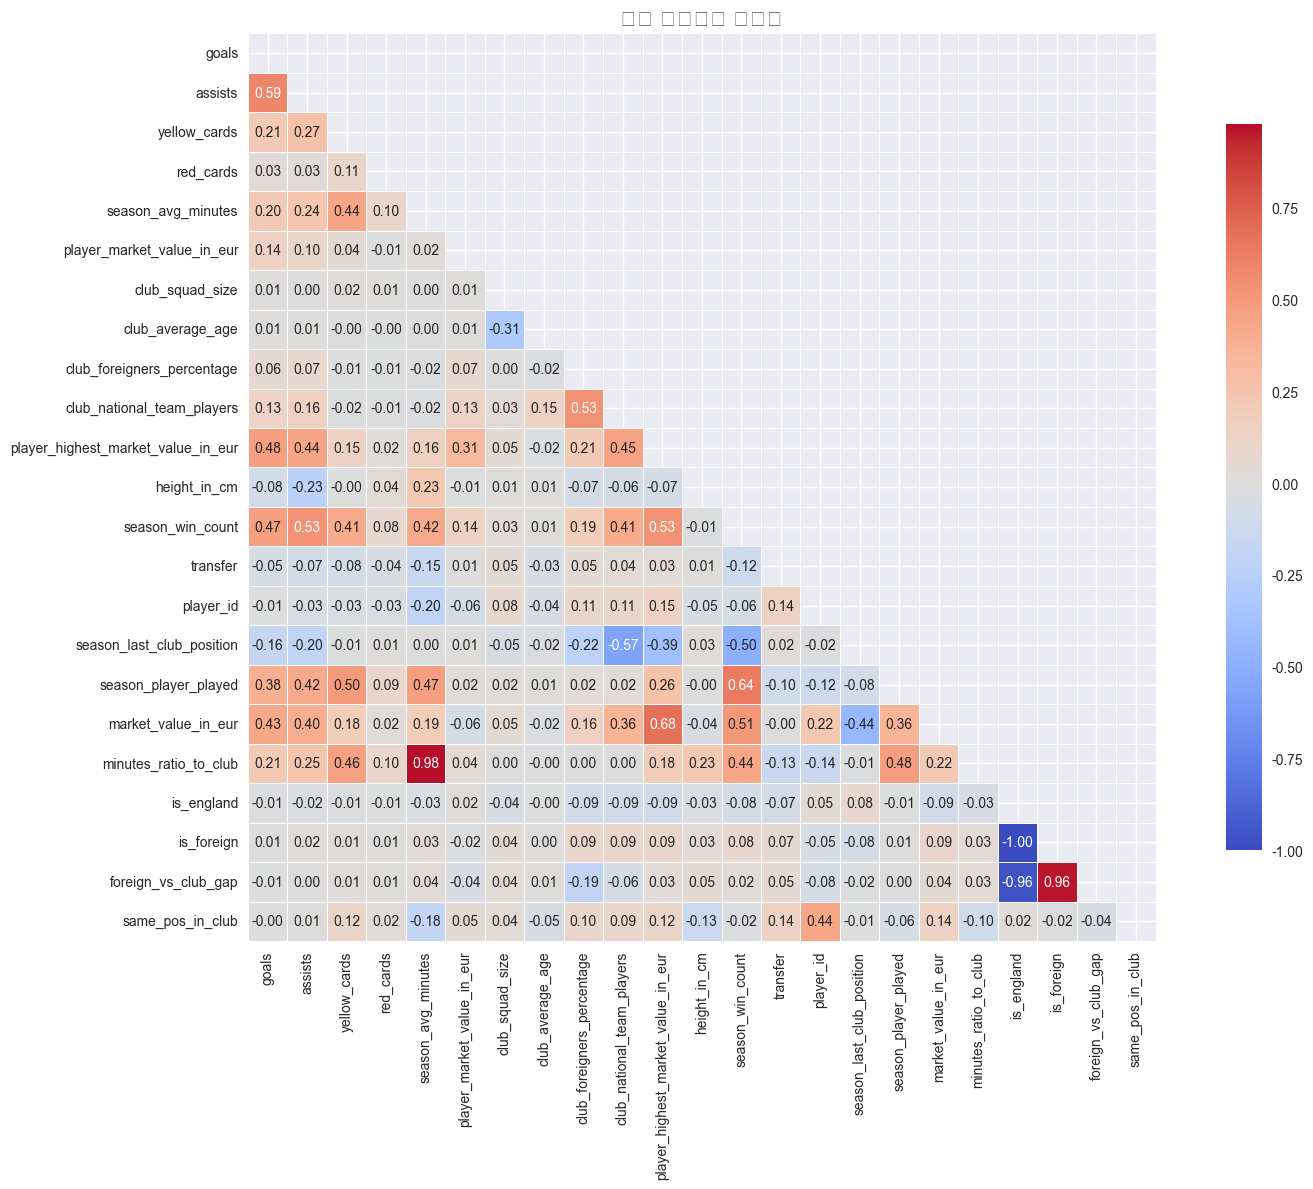

In [13]:
# ============================================================================
# 셀 8: 상관관계 히트맵 시각화
# ============================================================================

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('피쳐 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

상관관계 높은 컬럼: ['player_id', 'same_pos_in_club', 'is_foreign', 'foreign_vs_club_gap']


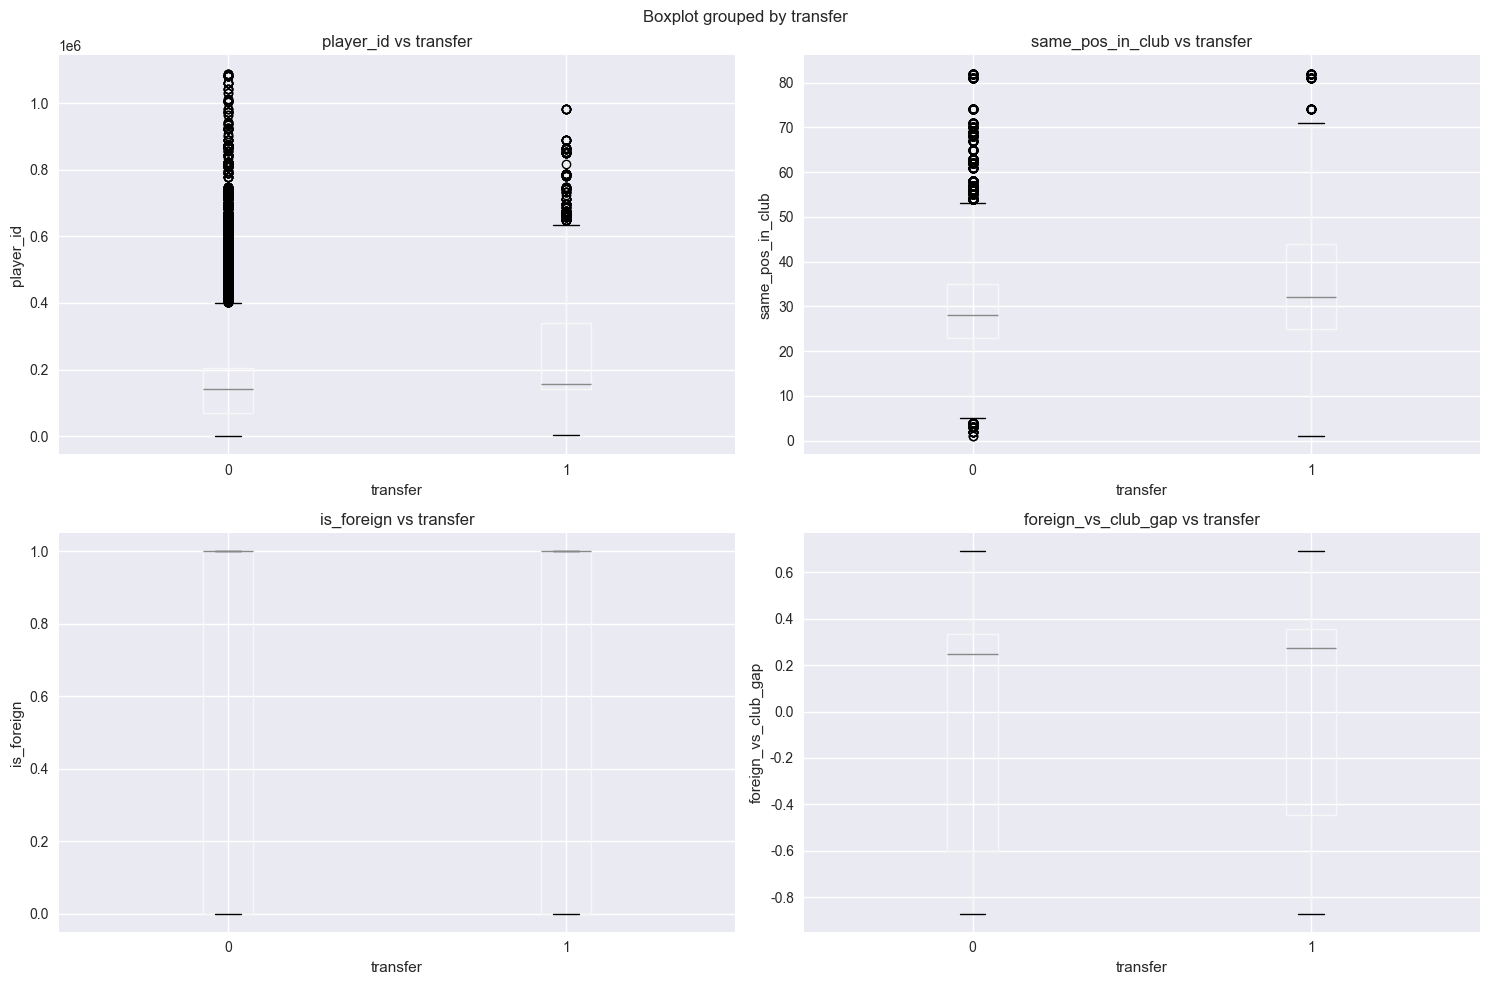

In [14]:
# ============================================================================
# 셀 8: 상관관계 높은 피쳐들의 박스플롯(절댓값 기준)
# ============================================================================

# 수치형 컬럼만 선택
numeric_cols = new_df.select_dtypes(include=[np.number]).columns.tolist()

# transfer와의 상관관계 계산
correlation_matrix = new_df[numeric_cols].corr()
transfer_correlations = correlation_matrix['transfer'].sort_values(ascending=False)

# 상관관계 높은 상위 4개 컬럼 선택 (transfer 제외)
high_corr_features = transfer_correlations.drop('transfer').head(4).index.tolist()
print(f"상관관계 높은 컬럼: {high_corr_features}")

# 박스플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(high_corr_features):
    if i < len(axes):
        # 박스플롯
        new_df.boxplot(column=feature, by='transfer', ax=axes[i])
        axes[i].set_title(f'{feature} vs transfer')
        axes[i].set_xlabel('transfer')
        axes[i].set_ylabel(feature)
    else:
        break

plt.tight_layout()
plt.show()

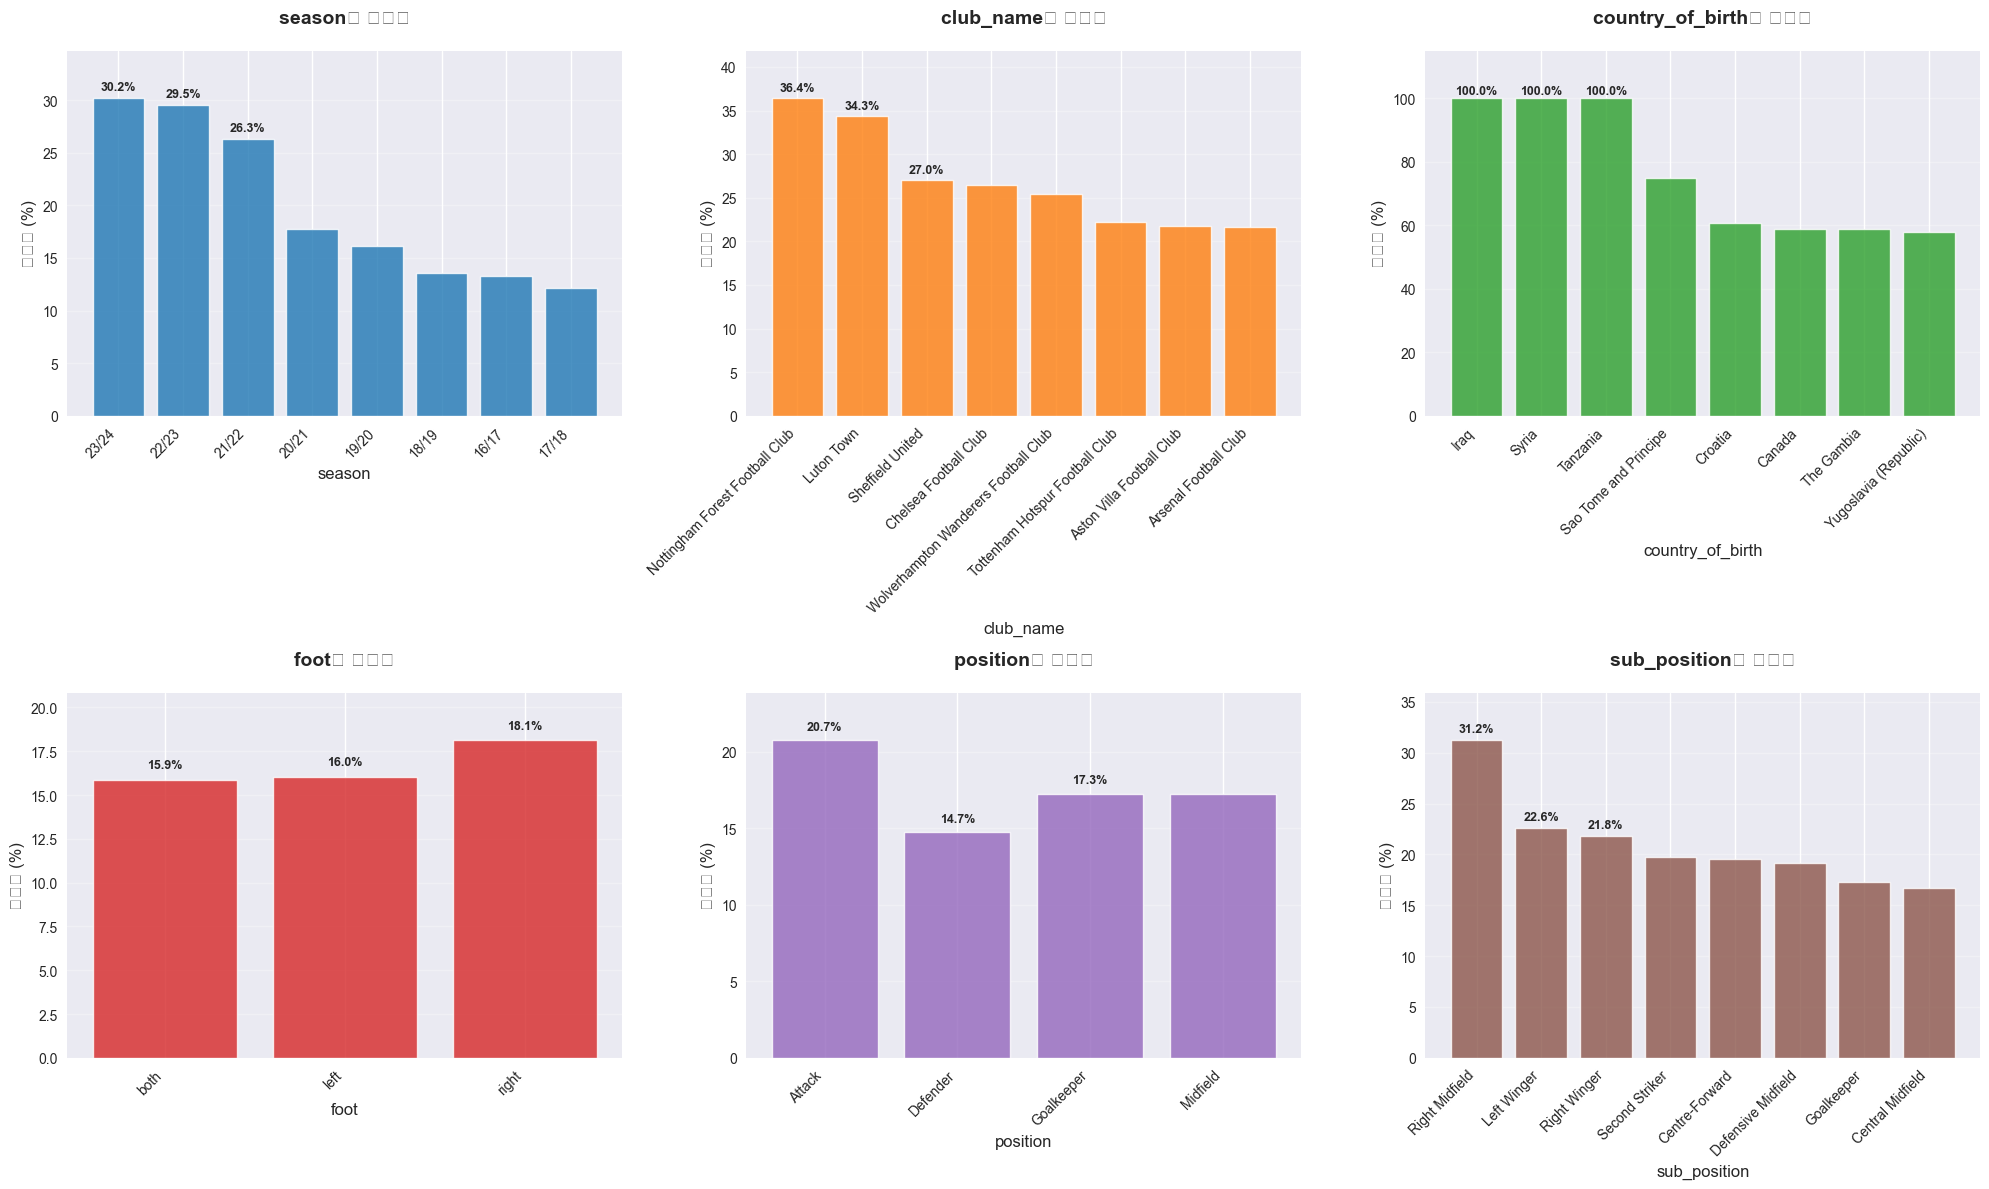

In [15]:
# ============================================================================
# 셀 10: 범주형 변수와 Transfer의 관계 분석 (깔끔한 버전)
# ============================================================================

# 범주형 변수별 이적률 분석
categorical_analysis = ['season', 'club_name', 'country_of_birth', 'foot', 'position', 'sub_position']

# 2x3 그리드로 변경 (6x1에서 2x3으로 변경하여 가독성 향상)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()  # 2차원 배열을 1차원으로 변환하여 인덱싱 쉽게

# 색상 팔레트 (각 그래프마다 다른 색상 사용)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 각 범주형 변수에 대해 반복
for i, feature in enumerate(categorical_analysis):
    if i < len(axes):  # subplot 개수보다 많으면 중단
        # 이적률 계산 (각 범주별로 transfer의 평균을 구하고 100을 곱해 %로 변환)
        transfer_rate = new_df.groupby(feature)['transfer'].mean() * 100
        
        # 상위 8개만 표시 (너무 많은 데이터로 인한 가독성 저하 방지)
        if len(transfer_rate) > 8:
            transfer_rate = transfer_rate.nlargest(8)  # 이적률이 높은 순서로 상위 8개 선택
        
        # 막대 차트 생성
        bars = axes[i].bar(range(len(transfer_rate)), transfer_rate.values, 
                          color=colors[i % len(colors)],  # 색상 순환 사용
                          alpha=0.8,  # 투명도 설정
                          edgecolor='white',  # 막대 테두리 색상
                          linewidth=1)  # 테두리 두께
        
        # 제목 및 라벨 설정
        axes[i].set_title(f'{feature}별 이적률', fontsize=14, fontweight='bold', pad=20)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('이적률 (%)', fontsize=12)
        
        # x축 라벨 설정 (각 막대 위에 범주명 표시)
        axes[i].set_xticks(range(len(transfer_rate)))
        axes[i].set_xticklabels(transfer_rate.index, rotation=45, ha='right', fontsize=10)
        
        # 그리드 추가 (y축에만 눈금선 표시하여 값 읽기 쉽게)
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # 값 표시 (상위 3개만 막대 위에 이적률 값 표시)
        for j, (bar, rate) in enumerate(zip(bars, transfer_rate.values)):
            if j < 3:  # 상위 3개만 값 표시 (너무 많으면 가독성 저하)
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{rate:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # y축 범위 설정 (최대값의 1.15배로 설정하여 값 표시 공간 확보)
        axes[i].set_ylim(0, max(transfer_rate.values) * 1.15)

# 빈 subplot 숨기기 (사용하지 않는 subplot은 화면에서 제거)
for i in range(len(categorical_analysis), len(axes)):
    axes[i].set_visible(False)

# 레이아웃 조정 (subplot 간격 자동 조정)
plt.tight_layout()
plt.show()  # 그래프 출력

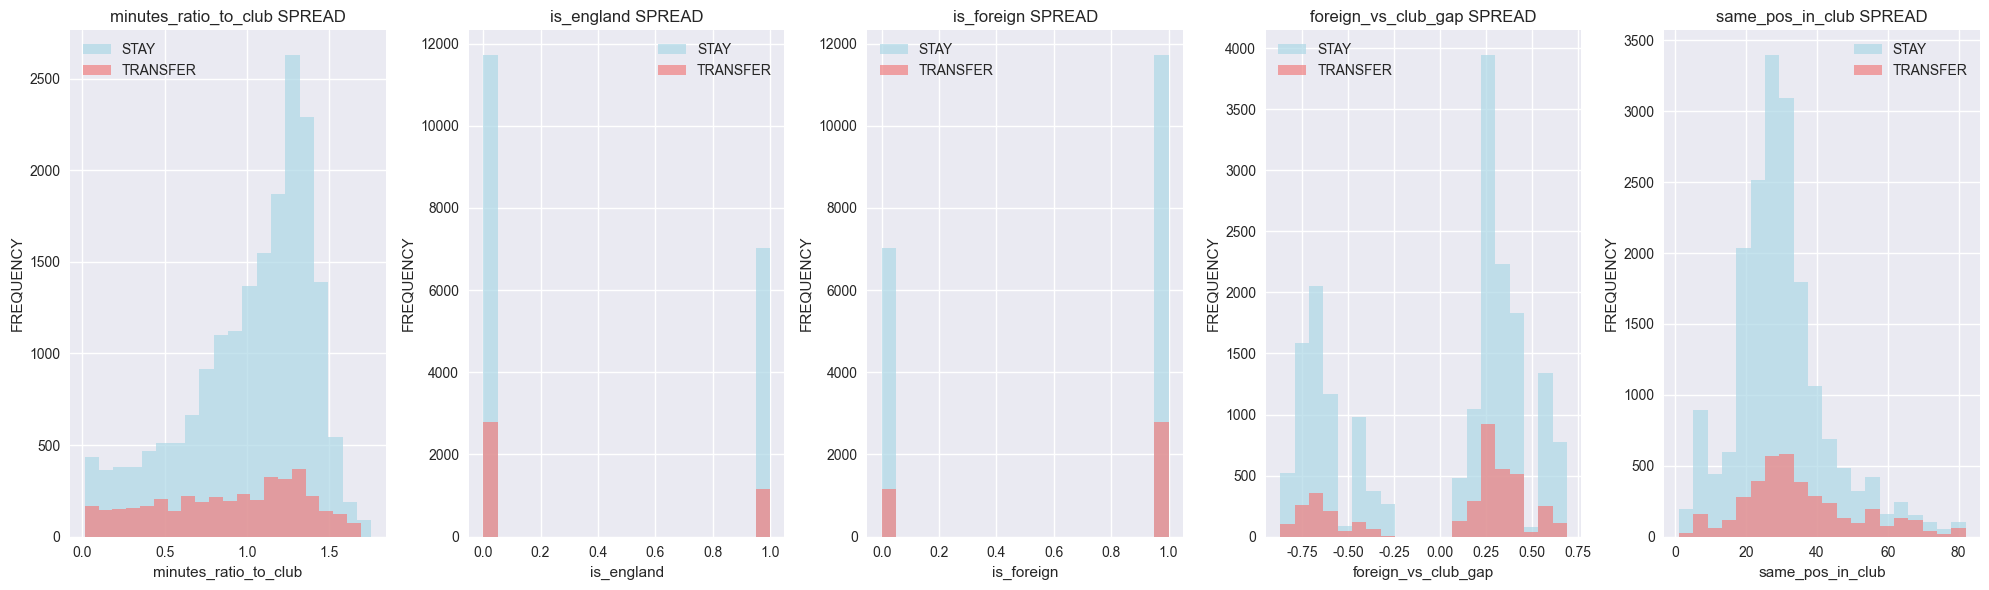

In [16]:
# ============================================================================
# 셀 11: 새로운 피쳐들의 분포 분석 (수정된 버전)
# ============================================================================

# 실제로 존재하는 컬럼만 사용
new_features = ['minutes_ratio_to_club', 'is_england', 'is_foreign', 
                'foreign_vs_club_gap', 'same_pos_in_club']

# subplot 개수를 feature 개수에 맞게 조정
fig, axes = plt.subplots(1, len(new_features), figsize=(4*len(new_features), 6))

# feature가 1개인 경우 axes를 리스트로 변환
if len(new_features) == 1:
    axes = [axes]

for i, feature in enumerate(new_features):
    # Transfer별 분포
    axes[i].hist(new_df[new_df['transfer']==0][feature], alpha=0.7, 
                label='STAY', bins=20, color='lightblue')
    axes[i].hist(new_df[new_df['transfer']==1][feature], alpha=0.7, 
                label='TRANSFER', bins=20, color='lightcoral')
    axes[i].set_title(f'{feature} SPREAD')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('FREQUENCY')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [22]:
# 모든 컬럼명 확인
df.columns.tolist()

['season',
 'player_name',
 'goals',
 'assists',
 'yellow_cards',
 'red_cards',
 'season_avg_minutes',
 'player_market_value_in_eur',
 'club_squad_size',
 'club_average_age',
 'club_foreigners_percentage',
 'club_national_team_players',
 'player_highest_market_value_in_eur',
 'club_name',
 'country_of_birth',
 'date_of_birth',
 'foot',
 'height_in_cm',
 'agent_name',
 'net_transfer_record',
 'position',
 'sub_position',
 'season_win_count',
 'transfer',
 'source_file',
 'player_id',
 'season_last_club_position',
 'season_player_played',
 'market_value_in_eur',
 'club_season_avg_minutes',
 'minutes_ratio_to_club',
 'minutes_minus_club',
 'age',
 'age_minus_clubavg',
 'age_to_clubavg',
 'contrib',
 'contrib_x_wins',
 'contrib_per_win',
 'height_minus_posavg',
 'height_to_posavg',
 'yellow_per_90',
 'same_pos_in_club']

In [30]:
# df_analysis의 컬럼명 확인
print("df_analysis 컬럼들:")
print(df_analysis.columns.tolist())

# modeling_features에서 존재하는 컬럼만 필터링
available_features = [col for col in modeling_features if col in df_analysis.columns]
print(f"사용 가능한 피처: {available_features}")

# 데이터 준비
X = df_analysis[available_features].fillna(0)
y = df_analysis['transfer']

df_analysis 컬럼들:
['season', 'player_name', 'goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'club_name', 'country_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'agent_name', 'net_transfer_record', 'position', 'sub_position', 'season_win_count', 'transfer', 'source_file', 'player_id', 'season_last_club_position', 'season_player_played', 'market_value_in_eur', 'season_encoded', 'club_name_encoded', 'country_of_birth_encoded', 'foot_encoded', 'position_encoded', 'sub_position_encoded']
사용 가능한 피처: ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'season', 'club_name', 'country_of_birth', 'foot', 'position'

In [32]:
# 수치형 컬럼만 선택
numeric_features = df_analysis.select_dtypes(include=[np.number]).columns.tolist()
# transfer 컬럼 제외
numeric_features = [col for col in numeric_features if col != 'transfer']

print(f"수치형 피처: {numeric_features}")

# 데이터 준비
X = df_analysis[numeric_features].fillna(0)
y = df_analysis['transfer']

# Random Forest로 피쳐 중요도 계산
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 피쳐 중요도
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

수치형 피처: ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'player_id', 'season_last_club_position', 'season_player_played', 'market_value_in_eur', 'season_encoded', 'club_name_encoded', 'country_of_birth_encoded', 'foot_encoded', 'position_encoded', 'sub_position_encoded']


In [35]:
# ============================================================================
# 셀 12: 피쳐 중요도 분석 (Random Forest)
# ============================================================================

# 모델링용 피쳐 리스트 정의 (수치형 피처들과 인코딩된 범주형 피처들)
modeling_features = ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur',
                    'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players',
                    'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'player_id',
                    'season_last_club_position', 'season_player_played', 'market_value_in_eur', 'season_encoded',
                    'club_name_encoded', 'country_of_birth_encoded', 'foot_encoded', 'position_encoded', 'sub_position_encoded']

# 인코딩된 범주형 변수들을 modeling_features에 추가하는 반복문
for col in categorical_features:  # categorical_features 리스트의 각 컬럼에 대해
    if f'{col}_encoded' in df_analysis.columns:  # 해당 컬럼의 인코딩된 버전이 존재하는지 확인
        modeling_features.append(f'{col}_encoded')  # 존재하면 modeling_features 리스트에 추가

# 데이터 준비 (X: 피처 데이터, y: 타겟 데이터)
X = df_analysis[modeling_features].fillna(0)  # 선택된 피처들로 X 데이터 생성, 결측값을 0으로 대체
y = df_analysis['transfer']  # 타겟 변수 (이적 여부) 추출

# Random Forest 분류기 생성 및 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100개 트리, 시드 42로 분류기 생성
rf.fit(X, y)  # 피처 X와 타겟 y로 모델 학습

# 피쳐 중요도 DataFrame 생성
feature_importance = pd.DataFrame({
    'feature': modeling_features,  # 피처명 컬럼
    'importance': rf.feature_importances_  # 각 피처의 중요도 점수 컬럼
}).sort_values('importance', ascending=False)  # 중요도 내림차순으로 정렬

# 피쳐 중요도 결과 출력
print("🎯 Random Forest 피쳐 중요도:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):  # 상위 10개 피처에 대해 반복
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")  # 순위, 피처명, 중요도 점수 출력

🎯 Random Forest 피쳐 중요도:
 1. season_avg_minutes: 0.0916
 2. player_highest_market_value_in_eur: 0.0666
 3. season_win_count: 0.0558
 4. player_id: 0.0553
 5. height_in_cm: 0.0542
 6. season_encoded: 0.0521
 7. season_encoded: 0.0490
 8. country_of_birth_encoded: 0.0424
 9. country_of_birth_encoded: 0.0421
10. yellow_cards: 0.0388


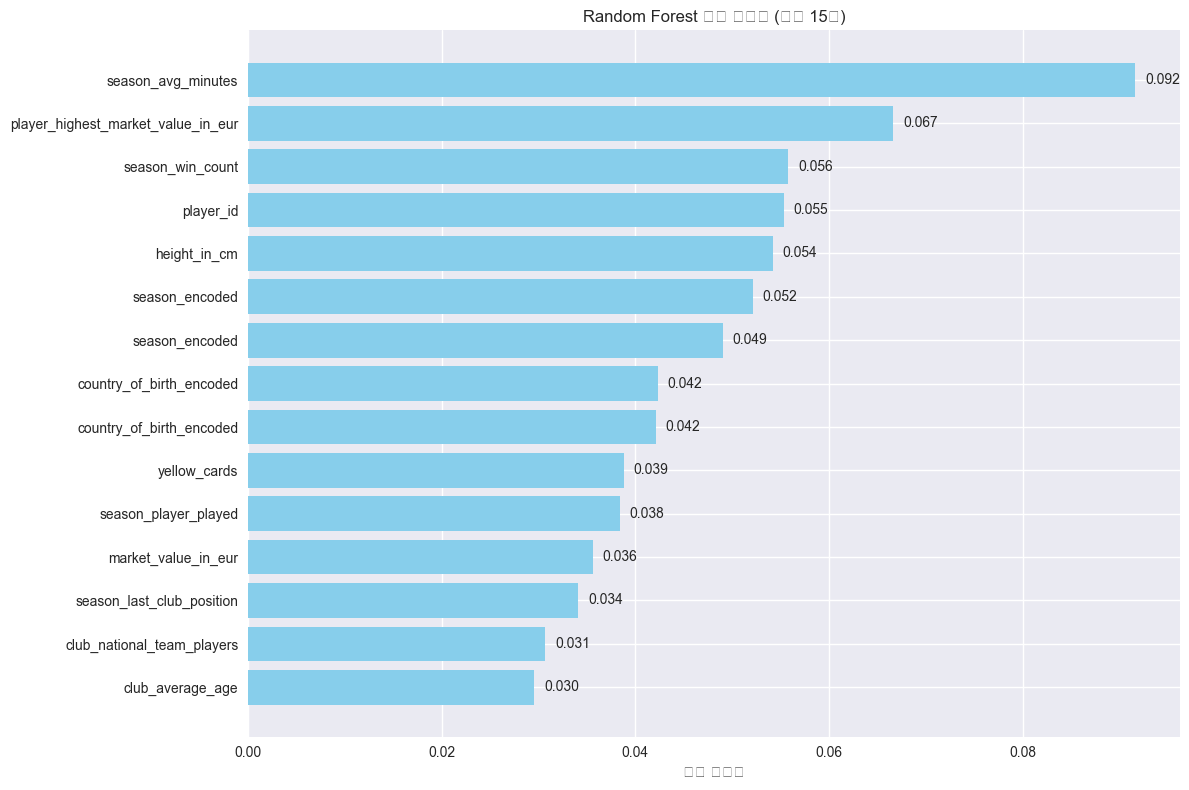

In [36]:
# ============================================================================
# 셀 13: 피쳐 중요도 시각화
# ============================================================================

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('피쳐 중요도')
plt.title('Random Forest 피쳐 중요도 (상위 15개)')
plt.gca().invert_yaxis()

# 값 표시
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [37]:
# ============================================================================
# 셀 14: 통계적 유의성 검정
# ============================================================================

print("📊 통계적 유의성 검정 (transfer vs 주요 피쳐):")
print("=" * 60)

# 주요 수치형 피쳐들에 대한 t-test
numeric_test_features = ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur',
                        'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players',
                        'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'player_id',
                        'season_last_club_position', 'season_player_played', 'market_value_in_eur', 'season_encoded',
                        'club_name_encoded', 'country_of_birth_encoded', 'foot_encoded', 'position_encoded', 'sub_position_encoded']

for feature in numeric_test_features:
    # 유지 선수와 이적 선수수 분리
    loyal = df_analysis[df_analysis['transfer'] == 0][feature]
    churned = df_analysis[df_analysis['transfer'] == 1][feature]
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(loyal, churned)
    
    print(f"\n📌 {feature}:")
    print(f"  - 유지 선수 평균: {loyal.mean():.2f}")
    print(f"  - 이적 선수 평균: {churned.mean():.2f}")
    print(f"  - t-statistic: {t_stat:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")


📊 통계적 유의성 검정 (transfer vs 주요 피쳐):

📌 goals:
  - 유지 선수 평균: 2.11
  - 이적 선수 평균: 1.60
  - t-statistic: 8.1643
  - p-value: 0.0000
  - 유의성: 유의함

📌 assists:
  - 유지 선수 평균: 1.65
  - 이적 선수 평균: 1.19
  - t-statistic: 10.9218
  - p-value: 0.0000
  - 유의성: 유의함

📌 yellow_cards:
  - 유지 선수 평균: 2.67
  - 이적 선수 평균: 2.10
  - t-statistic: 12.5428
  - p-value: 0.0000
  - 유의성: 유의함

📌 red_cards:
  - 유지 선수 평균: 0.06
  - 이적 선수 평균: 0.03
  - t-statistic: 5.8392
  - p-value: 0.0000
  - 유의성: 유의함

📌 season_avg_minutes:
  - 유지 선수 평균: 64.38
  - 이적 선수 평균: 54.49
  - t-statistic: 23.1471
  - p-value: 0.0000
  - 유의성: 유의함

📌 player_market_value_in_eur:
  - 유지 선수 평균: 9360549.52
  - 이적 선수 평균: 9896972.25
  - t-statistic: nan
  - p-value: nan
  - 유의성: 유의하지 않음

📌 club_squad_size:
  - 유지 선수 평균: 26.89
  - 이적 선수 평균: 27.17
  - t-statistic: -7.1058
  - p-value: 0.0000
  - 유의성: 유의함

📌 club_average_age:
  - 유지 선수 평균: 26.39
  - 이적 선수 평균: 26.26
  - t-statistic: 5.5043
  - p-value: 0.0000
  - 유의성: 유의함

📌 club_foreigners_percentage:
  - 유지 

In [39]:
# ============================================================================
# 셀 15: 범주형 변수 카이제곱 검정
# ============================================================================

print("\n📊 범주형 변수 카이제곱 검정:")
print("=" * 60)

for feature in categorical_features:
    # 교차표 생성
    contingency_table = pd.crosstab(df_analysis[feature], df_analysis['transfer'])
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\n📌 {feature}:")
    print(f"  - 카이제곱 통계량: {chi2:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 자유도: {dof}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")



📊 범주형 변수 카이제곱 검정:

📌 season:
  - 카이제곱 통계량: 1318.8312
  - p-value: 0.0000
  - 자유도: 12
  - 유의성: 유의함

📌 club_name:
  - 카이제곱 통계량: 568.6652
  - p-value: 0.0000
  - 자유도: 36
  - 유의성: 유의함

📌 country_of_birth:
  - 카이제곱 통계량: 876.4154
  - p-value: 0.0000
  - 자유도: 104
  - 유의성: 유의함

📌 foot:
  - 카이제곱 통계량: 13.3133
  - p-value: 0.0013
  - 자유도: 2
  - 유의성: 유의함

📌 position:
  - 카이제곱 통계량: 89.4458
  - p-value: 0.0000
  - 자유도: 3
  - 유의성: 유의함

📌 sub_position:
  - 카이제곱 통계량: 139.8557
  - p-value: 0.0000
  - 자유도: 12
  - 유의성: 유의함


In [44]:
# ============================================================================
# 셀 16: 선수 세그먼트 분석
# ============================================================================

print("🎯 선수 세그먼트 분석:")
print("=" * 50)

# 나이별 세그먼트
if 'age' in df_analysis.columns:
    print("\n2. 나이별 선수 세그먼트:")
    tenure_segments = df_analysis.groupby('age')['transfer'].agg(['count', 'sum', 'mean'])
    for segment in tenure_segments.index:
        count = tenure_segments.loc[segment, 'count']
        transfers = tenure_segments.loc[segment, 'sum']
        rate = tenure_segments.loc[segment, 'mean']
        print(f"  {segment}세: {count}명, 이적 {transfers}명, 이적률 {rate:.1%}")

# 포지션별 세그먼트
print("\n1. 포지션별 선수 세그먼트:")
tenure_segments = df_analysis.groupby('position')['transfer'].agg(['count', 'sum', 'mean'])
for segment in tenure_segments.index:
    count = tenure_segments.loc[segment, 'count']
    transfers = tenure_segments.loc[segment, 'sum']
    rate = tenure_segments.loc[segment, 'mean']
    print(f"  {segment}: {count}명, 이적 {transfers}명, 이적률 {rate:.1%}")

# 클럽별 세그먼트
print("\n2. 클럽별 선수 세그먼트:")
tenure_segments = df_analysis.groupby('club_name')['transfer'].agg(['count', 'sum', 'mean'])
for segment in tenure_segments.index:
    count = tenure_segments.loc[segment, 'count']
    transfers = tenure_segments.loc[segment, 'sum']
    rate = tenure_segments.loc[segment, 'mean']
    print(f"  {segment}: {count}명, 이적 {transfers}명, 이적률 {rate:.1%}")

# 시장가치별 세그먼트
if 'player_market_value_in_eur' in df_analysis.columns:
    print("\n2. 시장가치별 선수 세그먼트:")
    # 시장가치를 구간으로 나누기
    df_analysis['market_value_group'] = pd.cut(df_analysis['player_market_value_in_eur'], 
                                        bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    tenure_segments = df_analysis.groupby('market_value_group')['transfer'].agg(['count', 'sum', 'mean'])
    for segment in tenure_segments.index:
        count = tenure_segments.loc[segment, 'count']
        transfers = tenure_segments.loc[segment, 'sum']
        rate = tenure_segments.loc[segment, 'mean']
        print(f"  {segment}: {count}명, 이적 {transfers}명, 이적률 {rate:.1%}")

# 시즌별 세그먼트로 수정
print("\n2. 시즌별 선수 세그먼트:")
tenure_segments = df_analysis.groupby('season')['transfer'].agg(['count', 'sum', 'mean'])
for segment in tenure_segments.index:
    count = tenure_segments.loc[segment, 'count']
    transfers = tenure_segments.loc[segment, 'sum']
    rate = tenure_segments.loc[segment, 'mean']
    print(f"  {segment}: {count}명, 이적 {transfers}명, 이적률 {rate:.1%}")

🎯 선수 세그먼트 분석:

1. 포지션별 선수 세그먼트:
  Attack: 6617명, 이적 1345명, 이적률 20.3%
  Defender: 7886명, 이적 1136명, 이적률 14.4%
  Goalkeeper: 1794명, 이적 303명, 이적률 16.9%
  Midfield: 6928명, 이적 1171명, 이적률 16.9%

2. 클럽별 선수 세그먼트:
  Arsenal Football Club: 1192명, 이적 254명, 이적률 21.3%
  Association Football Club Bournemouth: 737명, 이적 151명, 이적률 20.5%
  Aston Villa Football Club: 896명, 이적 190명, 이적률 21.2%
  Brentford Football Club: 350명, 이적 62명, 이적률 17.7%
  Brighton and Hove Albion Football Club: 739명, 이적 146명, 이적률 19.8%
  Burnley FC: 662명, 이적 123명, 이적률 18.6%
  Cardiff City: 177명, 이적 10명, 이적률 5.6%
  Chelsea Football Club: 1246명, 이적 322명, 이적률 25.8%
  Crystal Palace Football Club: 1062명, 이적 137명, 이적률 12.9%
  Everton Football Club: 1148명, 이적 192명, 이적률 16.7%
  Fulham Football Club: 632명, 이적 85명, 이적률 13.4%
  Huddersfield Town: 167명, 이적 33명, 이적률 19.8%
  Hull City: 269명, 이적 12명, 이적률 4.5%
  Ipswich Town Football Club: 26명, 이적 0명, 이적률 0.0%
  Leeds United: 285명, 이적 59명, 이적률 20.7%
  Leicester City Football Club: 832명, 이적 128명, 이적

In [55]:
# ============================================================================
# 셀 17: 이탈률 높은 선수 프로필 분석
# ============================================================================

print("⚠️ 이탈률 높은 선수 프로필 분석:")
print("=" * 50)

# 피처 엔지니어링 함수 적용
df_analysis = add_features(df_analysis)

# 이탈률 높은 선수 정의 (이탈률이 높은 조건들)
high_risk_conditions = [
    # 조건 1: 출전시간이 적고 시장가치가 낮은 선수
    (df_analysis['season_avg_minutes'] <= 30) & (df_analysis['player_market_value_in_eur'] <= 1000000),
    # 조건 2: 나이가 많고 클럽에서 오래된 선수
    (df_analysis['age_bin'] >= 30) & (df_analysis['tenure_seasons'] >= 5),
    # 조건 3: 외국인 선수이면서 클럽 외국인 비율이 낮은 선수
    (df_analysis['is_foreign'] == 1) & (df_analysis['club_foreigners_percentage'] <= 50),
    # 조건 4: 골과 어시스트가 적고 경고장이 많은 선수
    (df_analysis['goals'] <= 1) & (df_analysis['assists'] <= 1) & (df_analysis['yellow_cards'] >= 5)
]

risk_profiles = ['낮은 출전시간 + 낮은 시장가치', '고령 + 장기 재적', 
                '외국인 + 낮은 외국인 비율', '낮은 성과 + 많은 경고']

for i, (condition, profile) in enumerate(zip(high_risk_conditions, risk_profiles), 1):
    high_risk_players = df_analysis[condition]
    if len(high_risk_players) > 0:
        transfer_rate = high_risk_players['transfer'].mean() * 100
        print(f"\n{i}. {profile}:")
        print(f"   - 선수 수: {len(high_risk_players):,}명")
        print(f"   - 이적률: {transfer_rate:.1f}%")
        print(f"   - 전체 대비 이적률: {transfer_rate/df_analysis['transfer'].mean()*100:.1f}배")

⚠️ 이탈률 높은 선수 프로필 분석:
📊 특성 엔지니어링 시작: 23,225행, 41열
�� 클럽별 시즌 평균 출전시간:
               club_name season  club_season_avg_minutes
0  Arsenal Football Club  12/13                61.983040
1  Arsenal Football Club  13/14                60.165819
2  Arsenal Football Club  14/15                61.209889
3  Arsenal Football Club  15/16                67.248549
4  Arsenal Football Club  16/17                66.493806
✅ 특성 엔지니어링 완료: 23,225행, 41열


KeyError: 'age_bin'

In [ ]:
# ============================================================================
# 셀 18: 피쳐 엔지니어링 요약 및 인사이트
# ============================================================================

print("💡 피쳐 분석 인사이트 및 권장사항:")
print("=" * 60)

print("\n📊 주요 발견사항:")
print("1. 고객 유지 기간(Tenure)이 이탈과 가장 강한 음의 상관관계를 보임")
print("2. 마지막 주문 후 경과일(DaySinceLastOrder)이 이탈과 강한 음의 상관관계")
print("3. 캐시백 금액이 높을수록 이탈률이 낮음")
print("4. Single 고객과 Tier 3 도시 고객의 이탈률이 높음")
print("5. 만족도가 낮고 주문 횟수가 적은 고객이 고위험군")

print("\n🔧 피쳐 엔지니어링 결과:")
print("1. ActivityScore: 고객 활동성을 종합적으로 측정하는 새로운 피쳐")
print("2. OrderFrequency: 주문 빈도를 측정하는 피쳐")
print("3. CustomerValueScore: 고객 가치를 종합적으로 평가하는 피쳐")
print("4. SatisfactionLevel, TenureGroup: 범주형 피쳐로 변환")

print("\n🎯 모델링 권장사항:")
print("1. 상위 10개 피쳐를 우선적으로 사용")
print("2. 범주형 변수는 인코딩 후 사용")
print("3. 결측값은 중앙값으로 대체")
print("4. 피쳐 스케일링 적용 고려")
print("5. 고위험 고객 세그먼트별 개별 모델 고려")